In [1]:
import os
import nnmnkwii.datasets.jvs
from nnmnkwii.io import hts
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchaudio
import pytorch_lightning as pl
import itertools
from matplotlib import pyplot as plt
import pyworld as pw
import pysptk as ps
import numpy as np

/root/.pyenv/versions/3.10.9/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/root/.pyenv/versions/3.10.9/lib/python3.10/site-packages/torchaudio/_internal/module_utils.py:99: UserWarning: Failed to import soundfile. 'soundfile' backend is not available.
  warnings.warn("Failed to import soundfile. 'soundfile' backend is not available.")


# model load

In [2]:
pa = "logs/train/runs/2023-03-10_15-53-44/checkpoints/epoch_058.ckpt"

In [5]:
pa

'logs/train/runs/2023-03-10_15-53-44/checkpoints/epoch_058.ckpt'

In [3]:
from typing import List, Tuple

import hydra
from hydra import compose, initialize
import pyrootutils
from omegaconf import DictConfig
from pytorch_lightning import LightningDataModule, LightningModule, Trainer
from pytorch_lightning.loggers import Logger

pyrootutils.setup_root("../", indicator=".project-root", pythonpath=True)

PosixPath('/home/workspace')

In [4]:
with initialize(version_base=None, config_path="../configs"):
    cfg = compose(config_name="eval.yaml", return_hydra_config=True)

In [5]:
model = hydra.utils.instantiate(cfg.model)

/root/.pyenv/versions/3.10.9/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'net' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['net'])`.
  rank_zero_warn(


In [6]:
model.load_from_checkpoint("/home/workspace/logs/train/runs/2023-03-11_09-08-07/checkpoints/epoch_060.ckpt")
model.eval()

CrossModalLitModule(
  (net): CrossModal(
    (ue): UttrEncoder(
      (model): ModuleDict(
        (activation): GLU(dim=1)
        (conv1): Conv2d(1, 32, kernel_size=(3, 9), stride=(1, 1), padding=(1, 4), bias=False)
        (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(16, 64, kernel_size=(4, 8), stride=(2, 2), padding=(1, 3), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(32, 64, kernel_size=(4, 8), stride=(2, 2), padding=(1, 3), bias=False)
        (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv4): Conv2d(32, 16, kernel_size=(9, 5), stride=(9, 1), padding=(0, 2), bias=False)
      )
    )
    (ud): UttrDecoder(
      (model): ModuleDict(
        (activation): GLU(dim=1)
        (deconv1): ConvTranspose2d(16, 32, kernel_size=(9, 5), stride=(9, 1), padding=(0, 2), bias=False)
        

# eval

In [7]:
def plot_specgram(waveform, sample_rate, title="Spectrogram", xlim=None):
    waveform = waveform.numpy()
    print(waveform.shape)
    num_channels, num_frames = waveform.shape
    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(waveform[c], Fs=sample_rate)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
        if xlim:
            axes[c].set_xlim(xlim)
    figure.suptitle(title)
    plt.show(block=False)

In [8]:
root = "/media/licrum/B85C4A615C4A1B10/dataset/jvs_r9y9_ver1"
wav_paths = nnmnkwii.datasets.jvs.WavFileDataSource(root, categories=["parallel"])

In [9]:
# 94 95 6 3

In [9]:
x = torchaudio.load(wav_paths.collect_files()[898])[0]
tmp = torchaudio.load(wav_paths.collect_files()[1298])[0]
print(x.shape)
print(tmp.shape)

torch.Size([1, 201752])
torch.Size([1, 202028])


In [12]:
from src.data.dataset import ImageDataset
idatasets = ImageDataset(root="/media/licrum/B85C4A615C4A1B10/dataset/cross/images")

In [13]:
y = idatasets[4]
y2 = idatasets[5]

/home/workspace/src/data/dataset.py:40: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.random.choice(self.data[label][index])
/home/workspace/src/data/dataset.py:40: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.random.choice(self.data[label][index])


In [14]:
def ex_mc(x):
    f0, sp, ap = pw.wav2world(x.squeeze(0).to(torch.double).numpy(), 24000)
    mc = ps.sp2mc(sp, order=35, alpha=ps.util.mcepalpha(24000))
    mc = torch.from_numpy(mc.T)
    return mc, f0, sp, ap

In [15]:
def synth(mc, f0, ap):
    f0 = f0[:mc.shape[1]]
    ap = ap[:mc.shape[1]]
    mc = mc.T.numpy()
    sp = ps.mc2sp(mc, alpha=ps.util.mcepalpha(24000), fftlen=1024)
    sp = sp.astype(np.double)[:len(f0)]
    return pw.synthesize(f0, sp, ap, 24000)

In [16]:
x_mc, x_f0, x_sp, x_ap = ex_mc(x)
tmp_mc, tmp_f0, tmp_sp, tmp_ap = ex_mc(tmp)

In [17]:
print(x_mc.shape)

torch.Size([36, 1682])


## 元音声の再合成

In [32]:
xx = synth(x_mc, x_f0, x_ap)

In [33]:
import IPython.display
IPython.display.Audio(xx, rate=24000)

/tmp/ipykernel_617287/2825384265.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  plot_specgram(torch.tensor([xx]), sample_rate=24000, title="Original")


(1, 201840)


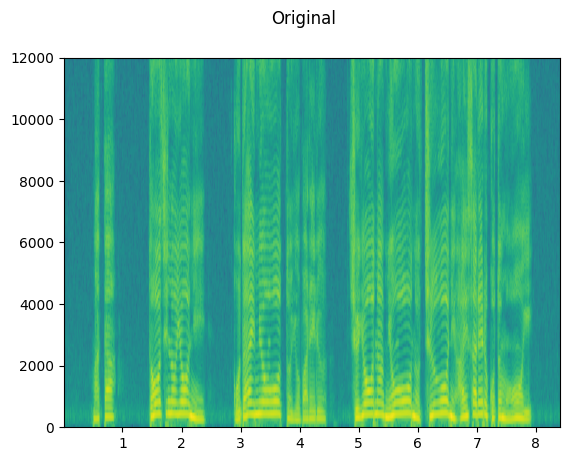

In [34]:
plot_specgram(torch.tensor([xx]), sample_rate=24000, title="Original")

In [83]:
tmptmp = synth(tmp_mc, tmp_f0, tmp_ap)

In [84]:
import IPython.display
IPython.display.Audio(tmptmp, rate=24000)

(1, 202080)


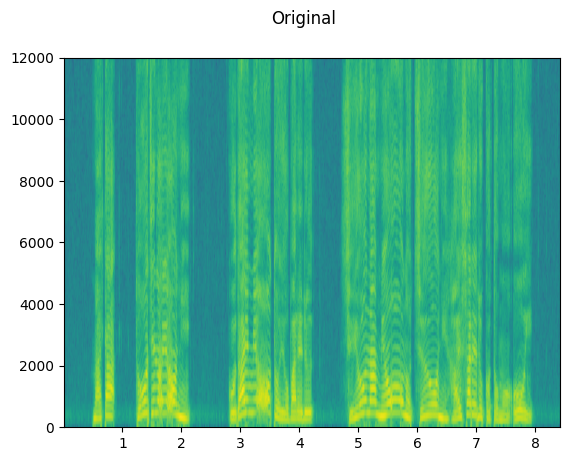

In [71]:
plot_specgram(torch.tensor([tmptmp]), sample_rate=24000, title="Original")

## 元音声の変換再合成

In [38]:
y_mc = model(x_mc.unsqueeze(0).unsqueeze(0).to(torch.float), y2.unsqueeze(0)).squeeze(0).squeeze(0)
y_mc = y_mc.detach()

In [39]:
yy = synth(y_mc, x_f0, x_ap)
yy = yy[2000:-2000]

In [40]:
import IPython.display
IPython.display.Audio(yy, rate=24000)

(1, 197600)


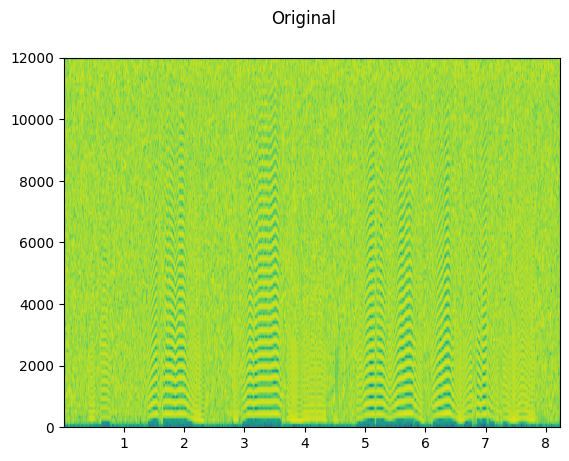

In [41]:
plot_specgram(torch.tensor([yy]), sample_rate=24000, title="Original")

### 2人目

In [42]:
y_mc = model(tmp_mc.unsqueeze(0).unsqueeze(0).to(torch.float), y.unsqueeze(0)).squeeze(0).squeeze(0)
y_mc = y_mc.detach()

In [43]:
y_mc

tensor([[-0.0032, -0.0497, -0.1002,  ..., -0.1001, -0.1097, -0.0903],
        [ 0.0372, -0.0258, -0.0744,  ..., -0.1199, -0.1296, -0.1167],
        [ 0.0373, -0.0104, -0.0767,  ..., -0.1014, -0.1242, -0.1174],
        ...,
        [ 0.0402, -0.0284, -0.0724,  ..., -0.1237, -0.1272, -0.1191],
        [ 0.0369, -0.0134, -0.0771,  ..., -0.1026, -0.1213, -0.1157],
        [ 0.0621,  0.0285,  0.0115,  ..., -0.0655, -0.0684, -0.0862]])

In [44]:
yy = synth(y_mc, tmp_f0, tmp_ap)
yy = yy[2000:-2000]

In [45]:
import IPython.display
IPython.display.Audio(yy, rate=24000)

(1, 198080)


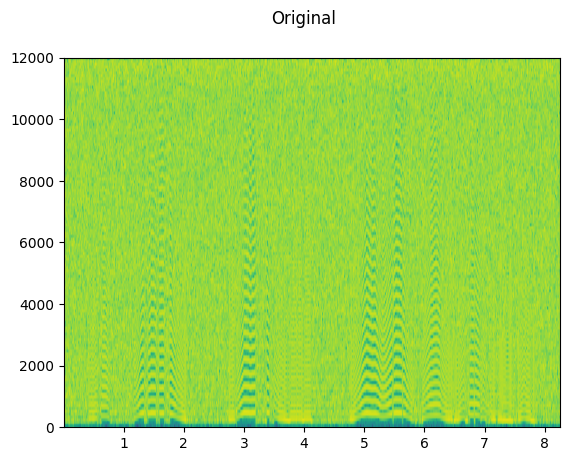

In [46]:
plot_specgram(torch.tensor([yy]), sample_rate=24000, title="Original")

## 画像の再構成確認

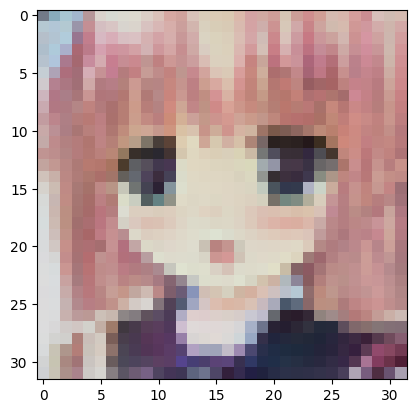

In [19]:
plt.imshow(y.to(torch.uint8).permute(1, 2, 0))

In [20]:
yy = model.net.rc_image(y2.unsqueeze(0))

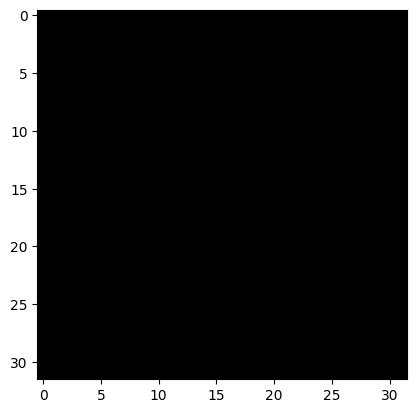

In [21]:
plt.imshow(yy.permute(1, 2, 0))

# メルケプストラム歪み

In [35]:
def calc_melcd(a_mcs, b_mcs):
    """
    input list(np.ndarray)
    """
    m = []
    for a, b in zip(a_mcs, b_mcs):
        min_cost, wp = librosa.sequence.dtw(a[1:, :], b[1:, :])
        m.append(melcd(a[:, wp[:,0]].T, b[:, wp[:,1]].T , lengths=None))
    return sum(m)/ len(a_mcs)

In [36]:
a = x_mc.numpy()
b = tmp_mc.numpy()
calc_melcd([a], [b])

NameError: name 'librosa' is not defined

# データ読み込み

In [ ]:
"""
x, y, z = [], [], []
for i in range(80):
    mx, _, _, _ = ex_mc(torchaudio.load(wav_paths.collect_files()[301+i])[0])
    my, _, _, _ = ex_mc(torchaudio.load(wav_paths.collect_files()[601+i])[0])
    x.append(mx)
    y.append(my)
    if True:
        mz = model(my.unsqueeze(0).unsqueeze(0).to(torch.float), y2.unsqueeze(0)).squeeze(0).squeeze(0)
        mz = mz.detach()
    z.append(mz)
"""

In [ ]:
#calc_melcd(x, y)

In [ ]:
#calc_melcd(x, z)